# PGM Laboratory: Classification with Tree Structured Models

Author: Aaron Helmers

This notebook requires:
* numpy  
* pandas  
* scipy  
* pymc3  
* patsy  

**warning**: pymc3 can be difficult to install. I was able to get it installed with [these instructions](http://stackoverflow.com/questions/42728877/using-pymc3-on-windows-10-theano-cannot-import-name-floatx?noredirect=1#comment72639271_42728877) along with [these instructions](http://deeplearning.net/software/theano/install_windows.html) taking the updated theanos from the former instruction set over the later.

## Problem statement
This laboratory comes from Daphne Kollor's Stanford Course on Probabalistic Graphical Models (PGM).

The goal is to be able to classify a body based on its pose. To do this, we have access to data for 10 different parts of the body: torso (0), head(1), left arm (2), left forearm (3), right arm (4), right forearm (5), left thigh (6), left leg (7), right thigh (8), and right leg (9). For each body part we also have access to 3 parameters: Y position, X position, and rotation (alpha).

The laboratory juxtaposes 2 methods of using this data to classify the body: A naive bayes model, and a conditional linear gaussian model (CLG).

## Load Data
The data we are loading was originally meant for matlab. To load the data, we will use scipy's io capabilities. The result of the load is a dictionary, where each key->value represents matrix_name->matrix. The matricies we are loading are:
* G1: The tree structure of a regular bayesian network, where each body part has only the body classification (class priors) as it's parent node.
* G2: The tree structure representing bodily connections for the CLG method of classification. This is to say that each body part, besides the torso, has another body part as a parent to learn from. all body parts also have the body classification as a parent. The structure of the data is [body_part][parent_type, parent].
* trainData / testData: The actual input data for our use. The structure of the data is [sample][body_part][parameter].

scipy.io loads the data strangly (there are extra, unneeded dimensions prepended), so we also extract it to the expected format listed above.

In [1]:
import scipy.io as sio

data = sio.loadmat('data/PA8Data.mat')
data['trainData'] = data['trainData'][0][0]
data['testData'] = data['testData'][0][0]
print (list(data))

['__header__', '__version__', '__globals__', 'G1', 'G2', 'trainData', 'testData']


Next, we want to convert from 1d numpy arrays to pandas dataframes. Since DataFrames must be 2D, we will create a dictionary from body_part->(sample, parameters)

In [2]:
import pandas as pd
import numpy as np
# reshape input data from [s,b,p] to {b, df(s,p)}
def reshape_data(samples):
    # convert from [s][b][p] to [s,b,p]
    retData = np.array(list(map(
        lambda sample: np.array(np.array(sample)),
        samples
    )))
    # convert from [s,b,p] to [b,s,p]
    retData = np.swapaxes(retData, 0, 1)
    # convert from [b,s,p] to {b: df(s,p)}
    retData = dict(map(
        lambda part_index: (part_index, pd.DataFrame(retData[part_index,:,:])),
        range(0, retData.shape[0])
    ))
    # give each DF proper column names
    for part in retData: 
        retData[part].columns = ['y', 'x', 'alpha']
    return retData

trainData = list(map(
    lambda label: reshape_data(
        data['trainData']['data'][np.where(data['trainData']['labels'][:,0] == label)]
    ), [0, 1]
))
testData = list(map(
    lambda label: reshape_data(
        data['testData']['data'][np.where(data['testData']['labels'][:,0] == label)]
    ), [0, 1]
    
))

print("Training Data (class=human(0), part=head(1)):")
print(trainData[0][1][:5])
print("\nTesting Data (class=human(0), part=head(1)):")
print(testData[0][1][:5])

Training Data (class=human(0), part=head(1)):
           y          x     alpha
0  22.977837   8.273512 -6.145974
1   8.363819  -1.982919 -0.115858
2  21.482629  38.584170 -6.267717
3 -19.544711 -24.646000 -5.760630
4  18.078155   8.942255 -5.676765

Testing Data (class=human(0), part=head(1)):
           y          x     alpha
0   0.688736  -9.333963 -0.374123
1  27.601101 -19.407871 -0.465951
2  19.320989  -6.411027 -0.481047
3 -23.182955  -1.804526 -6.082243
4 -19.615777  18.688371 -5.888298


## Develop Model
For the purpose of this laboratory, only the CLG method will be explored (G2). Originally G1 was included to juxtapose the naive bayes method with the CLG method.

The CLG method can be seen as determining the probability of a classification for the body by finding the probability of all body parts having that classification. Subsequently, each body part determine's it's probability of classification based on learned linear gaussian's whose mean is a linear combination the the classes prior probability the parent body part's parameters.

While doing research to complete this laboratory, 3 ways were found to fulfil the requirements:

1) The hardest is to write the models manually, which includes the writing of a method to solve the linear systems for each body_part-parameter-classification combination, or 60 linear systems in total. Then follow this up by writing a method to compute the log-likelihood for a testing sample to classify.  

2) pgmpy could be used to make life easier by creating a LinearGaussianCPD model for each body_part-parameter-classification combination. The benifit of this is that it makes the calculation of the log-likelihood much simpler by providing the probability of classification for each model. These models would then just have to be combined to compute the probability of classification. To create these models, however, we would still need to compute the parameters for each gaussian, which is a significant amount of work.  

3) pymc3 was then discovered which was capable of providing Generalized Linear Models (GLMs), which is precisely what we are looking to create. These take the capability of pgmpy above, but abstract away the work required to learn the gaussian parameters.      

Since pymc3 abstracts a lot of the complicated work away, it was used to solve our problems.

### 1) Reformulate Data Into Linear Gaussian Form
In order to utilize Pymc3, we need to reformulate each of our samples into (y<sub>parent</sub>, x<sub>parent</sub>, alpha<sub>parent</sub>, answer) form. This will allow us to have Pymc3 create models for each body part's parameter. The offset parameter is automatically calculated for us by Pymc3.

In [3]:
def as_paramed(data_in, class_prior):
    return dict(map(
        lambda part_index: (part_index, pd.DataFrame({
            'intercept': class_prior,
            'p_x': 0 if part_index == 0 else data_in[data['G2'][1,1]]['x'],
            'p_y': 0 if part_index == 0 else data_in[data['G2'][1,1]]['y'],
            'p_alpha':data_in[data['G2'][1,1]]['alpha'],
            'x': data_in[part_index]['x'],
            'y': data_in[part_index]['y'],
            'alpha': data_in[part_index]['alpha']
        })),
        range(0, len(data_in))
    ))

trainDataParamed = list(map(
    lambda label: as_paramed(
        trainData[label],
        trainData[label][0].shape[0] / data['trainData']['data'].shape[0]
    ), [0, 1]
))
testDataParamed = list(map(
    lambda label: as_paramed(
        testData[label],
        testData[label][0].shape[0] / data['trainData']['data'].shape[0]
    ), [0, 1]
))

print('Parameterized Training Data (class=human(0), part=head(1)):')
print(trainDataParamed[0][1][:5])
print('\nParameterized Testing Data (class=alien(1), part=right_leg(9)):')
print(trainDataParamed[1][9][:5])

Parameterized Training Data (class=human(0), part=head(1)):
      alpha  intercept   p_alpha        p_x        p_y          x          y
0 -6.145974   0.488889 -6.145974   8.273512  22.977837   8.273512  22.977837
1 -0.115858   0.488889 -0.115858  -1.982919   8.363819  -1.982919   8.363819
2 -6.267717   0.488889 -6.267717  38.584170  21.482629  38.584170  21.482629
3 -5.760630   0.488889 -5.760630 -24.646000 -19.544711 -24.646000 -19.544711
4 -5.676765   0.488889 -5.676765   8.942255  18.078155   8.942255  18.078155

Parameterized Testing Data (class=alien(1), part=right_leg(9)):
      alpha  intercept   p_alpha        p_x        p_y          x           y
0 -2.784688   0.511111 -5.659289  -8.290587 -30.099826 -27.125302   80.679541
1 -3.467803   0.511111 -0.168724 -26.986419 -35.347895  -2.146990   71.836016
2 -2.818784   0.511111 -6.181410   9.526765  22.749323 -30.957147  127.921171
3 -3.585914   0.511111 -6.281134   2.292619 -21.035900  42.804573   79.490427
4 -3.184570   0.511111 

### 2) Build Pymc3 Generalized Linear Models
We are going to start by building GLMs for each body part and classification, resulting in 20 GLMs in total. A normal probability distribution is assumed.

In [ ]:
import pymc3 as pm
from theano import shared

def generate_param_distro(label, part, param, sample_count):
    samples = trainDataParamed[label][part]
    means = samples.mean()
    stds = samples.std()
    print ('Generating for [%s,%s,%s]' % (label, part, param))
    with pm.Model() as model:
        if (part == 0): # is root, has no parent. distro defined directly by observed
            sigma = pm.Normal('sigma', samples[param].std(), 1)
            dist = pm.Normal(param, samples[param].mean(), samples[param].std())
        else:    
            #priors
            intercept = pm.Normal('intercept', mu=means[param], sd=stds[param])
            b_p_y = pm.Normal('p_y', mu=means['p_y'], sd=stds['p_y'])
            b_p_x = pm.Normal('p_x', mu=means['p_x'], sd=stds['p_x'])
            b_p_alpha = pm.Normal('p_alpha', mu=means['p_alpha'], sd=stds['p_alpha'])
            sigma = pm.HalfNormal('sigma', sd=1)
            # expected value of outcome
            mu = intercept + b_p_y*samples['p_y'].values + b_p_x*samples['p_x'].values + b_p_alpha*samples['p_alpha'].values
            # build/infer distribution
        trace = pm.sample(sample_count)
    return trace

def generate_body_distros(label, part, sample_count):
    return dict(map(
        lambda param: (param, generate_param_distro(label, part, param, sample_count)),
        ['y', 'x', 'alpha']
    ))

# Generate distributions as [{part: {param: model}}] where index is a classification (0, 1)
glms = list(map(
    lambda label: dict(map(
        lambda part: (part, generate_body_distros(label, part, 5000)),
        range(0, len(trainData[label]))
    )),
    [0, 1]
))

# Display
print ('Trace distributions for (label=human, part=head):')
# print (glms[0][1]['y'])

### 3) Define logic for prediction
First, we need the prediction logic.

In [78]:
import scipy as sp
from math import *

def sample_mean(param, coeffs, variables, is_root=False):
    if (is_root): # part is root, mean is only dependant on value
        mu = variables[param]
    else:
        mu = coeffs['intercept'] + coeffs['p_y']*variables['p_y'] + coeffs['p_x']*variables['p_x'] + coeffs['p_alpha']*variables['p_alpha']
    return mu

def param_posterior(label, part, param, variables):
    distro_stats = pm.df_summary(glms[label][part][param])['mean']
    mean = sample_mean(param, distro_stats, variables, part == 0)
    distro = sp.stats.norm.logpdf(variables[param], loc=mean, scale=distro_stats['sigma'])    
    return distro

def part_posterior(label, part, variables):
    x_prob = param_posterior(label, part, 'x', variables)
    y_prob = param_posterior(label, part, 'y', variables)
    alpha_prob = param_posterior(label, part, 'alpha', variables)
    return x_prob + y_prob + alpha_prob

def class_posterior(label, variables):
    class_prior = variables.loc[0]['intercept']
    part_probs = list(map(
        lambda part: part_posterior(label, part, variables.loc[part]) * log(class_prior),
        range(0, 10)
    ))
    return sum(part_probs)

def predict_class(variables):
    post0 = class_posterior(0, variables)
    post1 = class_posterior(1, variables)
    normalizer = post0 + post1
    post0 = post0 / normalizer
    post1 = post1 / normalizer
    return (0 if (post0 >= post1) else 1, post0, post1)

def predict_one(sample):
    prediction = predict_class(sample['data'])
    sample['prediction'] = prediction[0]
    sample['probabilities'] = [prediction[1], prediction[2]]
    return sample

def predict_all(samples):
    return list(map(
        lambda sample: predict_one(sample),
        samples   
    ))

Now we need to format our data into a way were we can index by sample instead of by body part.

In [6]:
def format_point_for_prediction(parts, sample=0):
    return list(map(
        lambda part: dict(parts[part].loc[sample]),
        range(0, len(parts))
    ))

def format_for_prediction(in_data):
    # covert [l,b,s] to [l,s,b] 
    flippedSamples = list(map(
        lambda label: list(map(
            lambda sample: pd.DataFrame(format_point_for_prediction(testDataParamed[label], sample)),
            range(0, len(in_data[label][0]))
        )),
        range(0, len(testDataParamed))
    ))
    # move label into sample
    retData = []
    for label in range(0, len(testDataParamed)):
        for sample in flippedSamples[label]:
            retData.append({
                'data': sample,
                'label': label
            })
    return retData

testDataFormated = format_for_prediction(testDataParamed)

Lastly, we test our work with a sample prediction.

In [7]:
# predict class label for sample 0
predict_class(testDataFormated[0]['data'])

(1, 0.2711634896726271, 0.72883651032737284)

## Evaluate Model
To evaluate our model, we are going to examine a confusion matrix across our loaded test data. We can also calculate accuracy, specificity, and precision.

The first step of evaluating the model is to actually apply it to test data.

In [8]:
import random

testDataPredicted = predict_all(testDataFormated)
testDataPredicted[0]

{'data':       alpha  intercept   p_alpha       p_x       p_y          x           y
 0 -3.400987   0.444444 -0.374123  0.000000  0.000000  -7.569149    7.222869
 1 -0.374123   0.444444 -0.374123 -9.333963  0.688736  -9.333963    0.688736
 2 -1.302784   0.444444 -0.374123 -9.333963  0.688736 -22.708795    7.728330
 3 -7.562699   0.444444 -0.374123 -9.333963  0.688736  24.568718   56.047027
 4 -5.499189   0.444444 -0.374123 -9.333963  0.688736  10.005413    4.593543
 5  2.297350   0.444444 -0.374123 -9.333963  0.688736 -11.392491   66.188674
 6 -2.569829   0.444444 -0.374123 -9.333963  0.688736  -2.200336   65.956361
 7 -2.658934   0.444444 -0.374123 -9.333963  0.688736 -29.696874  106.704019
 8 -4.232145   0.444444 -0.374123 -9.333963  0.688736  15.308749   64.840397
 9 -4.250539   0.444444 -0.374123 -9.333963  0.688736  57.451544   85.492153,
 'label': 0,
 'prediction': 1,
 'probabilities': [0.2711634896726271, 0.72883651032737284]}

Next, we make our confusion matrix (actually, crosstab).

In [9]:
from sklearn import metrics as met
testLabels = pd.Series(list(map(
    lambda test: test['label'],
    testDataPredicted
)))

testPredictions = pd.DataFrame(list(map(
    lambda test: (test['prediction'], test['probabilities'][test['prediction']]),
    testDataPredicted
)))
testPredictions.columns = ['prediction', 'confidence']

testLabelsNamed = pd.Series(list(map(
    lambda test: 'human' if (test['label'] == 0) else 'alien',
    testDataPredicted
)))

testPredictionsNamed = pd.Series(list(map(
    lambda test: 'human' if (test['prediction'] == 0) else 'alien',
    testDataPredicted
)))

# [TN] [FN]
# [FP] [TP]
crosstab = pd.crosstab(testLabelsNamed, testPredictionsNamed, rownames=['Label'], colnames=['Prediction'], margins=True)
crosstab

Prediction,alien,human,All
Label,,,
alien,67,133,200
human,99,101,200
All,166,234,400


In [10]:
testPredictions[:5]

,prediction,confidence
0,1,0.728837
1,1,0.587361
2,1,0.542378
3,0,0.529833
4,1,0.589235


In [11]:
accuracy = met.accuracy_score(testLabels, testPredictions['prediction'])
specificity = met.recall_score(testLabels, testPredictions['prediction']) # TP / P
precision = met.precision_score(testLabels, testPredictions['prediction']) # TP / TP + FP
print('Accuracy   : ' + str(accuracy))
print('Specificity: ' + str(specificity))
print('Precision  : ' + str(precision))

Accuracy   : 0.42
Specificity: 0.335
Precision  : 0.403614457831


finally, we will evaluate the model by viewing its ROC (Reciever Operator Characteristic) plot.

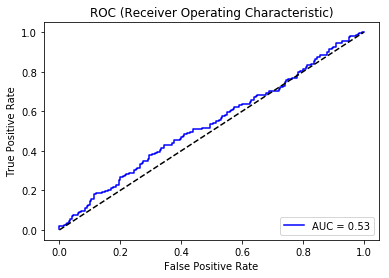

In [12]:
import matplotlib.pyplot as plt
fpr, tpr, _ = met.roc_curve(testLabels, testPredictions['confidence'])
auc = met.roc_auc_score(testLabels, testPredictions['confidence'])

plt.close()
plt.title('ROC (Receiver Operating Characteristic)')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()